In [1]:
import random
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
import gt4py as gt
import gt4py.cartesian.gtscript as gtscript

In [2]:
from common import (
    initialize_fields,
    plot_field,
    array_to_gt_storage
)

In [3]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

# Accelerate with GT4Py

We've already learnt about GT4Py on class. Here we explore its performance and other features under the new package version GT4Py 1.0.1. It needs to be marked here that the numpy version is 1.21.6, and python 3.9.4.

## Copy Stencils

In [4]:
def gt4py_copy_row_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):

    from __gtscript__ import PARALLEL, computation, interval
    
    with computation(PARALLEL), interval(...):
        out_field = in_field

def gt4py_copy_row_apply(in_field, out_field, N_ITER=1):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    domain = (
        in_field.shape[0],
        in_field.shape[1],
        in_field.shape[2]
    )
    # Iteration
    for iter in range(N_ITER):
        
        gt4py_copy_row_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
        return out_field

In [5]:
backend = "numpy"
gt4py_copy_row_stencil = gtscript.stencil(backend=backend, definition=gt4py_copy_row_def)

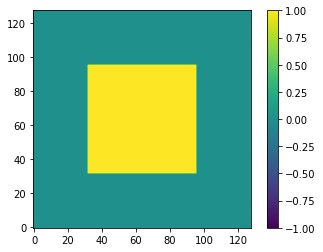

In [6]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square",ifirst=True)
in_field, out_field = array_to_gt_storage(in_field, out_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_copy_row_apply(in_field, out_field, N_ITER=N_ITER)
plot_field(out_field,ifirst=True)

In [7]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square",ifirst=True)
in_field, out_field = array_to_gt_storage(in_field, out_field, backend=backend, index=(0, 0, 0))
gt4py_copy_row_apply(in_field, out_field, N_ITER=N_ITER)

14 ms ± 68.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the case above we define origin (starting index) and domain (computation region without halos) manually, like we've learnt in class. Let's see if the performance change if we just use the default setting, which is possible in the new GT4Py 1.0.1. This greatly simplify the function and looks much more intuitive.

In [8]:
def gt4py_copy_row_default_apply(in_field, out_field, N_ITER=1):

    for iter in range(N_ITER):
        gt4py_copy_row_stencil(
            in_field=in_field,
            out_field=out_field
        )
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
        return out_field

Here the stencil function is the same as the previous one, so we don't need to compile again.

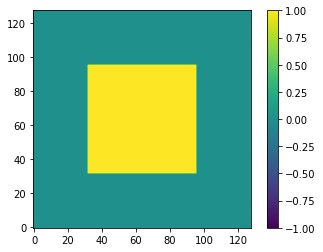

In [9]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", ifirst=True)
in_field, out_field = array_to_gt_storage(in_field, out_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_copy_row_default_apply(in_field, out_field, N_ITER=N_ITER)
plot_field(out_field, ifirst=True)

In [10]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", ifirst=True)
in_field, out_field = array_to_gt_storage(in_field, out_field, backend=backend, index=(0, 0, 0))
gt4py_copy_row_default_apply(in_field, out_field, N_ITER=N_ITER)

13.9 ms ± 97.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It seems decent as it's only under numpy mode (other modes like "gt:cpu_ifirst" is not working), but still slower than plain numpy or numba, probably due to the setup overheads.
The result also shows that in this case the index and domain information can be omitted, and GT4Py will find itself, which has no impact on execution time.

It's hard to implement Sin function using GT4Py, as functions like math.sin and np.sin cannot be imported inside a stencil, so there will not be any acceleration on sin calculation.

## 1D Stencils

Now we apply GT4Py to 1D stencil calculation. First is columnwise direction:

###  Same column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

In [16]:
def gt4py_1D_col_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):

    from __gtscript__ import PARALLEL, computation, interval
    
    with computation(PARALLEL), interval(...):
        # Apply 1D stencil in gt4py style
        out_field = 0.5 * (in_field[1, 0, 0] - in_field[0, 0, 0])

def gt4py_1D_col_apply(in_field, out_field, N_ITER=1):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    nx = in_field.shape[0] - 1
    domain = (
        nx,
        in_field.shape[1],
        in_field.shape[2]
    )
    # Iteration
    for iter in range(N_ITER):
        # Update halo value
        in_field[nx, :, :] = in_field[0, :, :]
        
        gt4py_1D_col_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

In [17]:
backend = "numpy"
gt4py_1D_col_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_col_def)

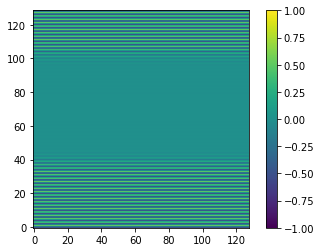

In [13]:
in_field, out_field = initialize_fields(NX+1, NY, NZ, mode="horizontal-bars", order="C", ifirst=True)
in_field, out_field = array_to_gt_storage(in_field, out_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_1D_col_apply(in_field, out_field, N_ITER=N_ITER)
plot_field(out_field, ifirst=True)

In [28]:
%%timeit
in_field, out_field = initialize_fields(NX+1, NY, NZ, mode="horizontal-bars", order="C", ifirst=True)
in_field, out_field = array_to_gt_storage(in_field, out_field, backend=backend, index=(0, 0, 0))
gt4py_1D_col_apply(in_field, out_field, N_ITER=N_ITER)

234 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Then we change the memory order to Fortran style to see if the duration change.

In [29]:
%%timeit
in_field, out_field = initialize_fields(NX+1, NY, NZ, mode="horizontal-bars", order="F", ifirst=True)
in_field, out_field = array_to_gt_storage(in_field, out_field, backend=backend, index=(0, 0, 0))
gt4py_1D_col_apply(in_field, out_field, N_ITER=N_ITER)

242 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The Fortran-style memory layout drags GT4Py a little bit but not much. This is quite impressive as it's the literally slower way to store the data. Other than here by GT4Py, only Numpy row-like methods close this gap perfectly.

Now let's check its performance with rowwise setup:

###  Same column: $a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]$

In [19]:
def gt4py_1D_row_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):

    from __gtscript__ import PARALLEL, computation, interval
    
    with computation(PARALLEL), interval(...):
        # Apply 1D stencil in gt4py style
        out_field = 0.5 * (in_field[0, 1, 0] - in_field[0, 0, 0])

def gt4py_1D_row_apply(in_field, out_field, N_ITER=1):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    ny = in_field.shape[1] - 1
    domain = (
        in_field.shape[0],
        ny,
        in_field.shape[2]
    )
    # Iteration
    for iter in range(N_ITER):
        # Update halo value
        in_field[:, ny, :] = in_field[:, 0, :]
        
        gt4py_1D_row_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

In [20]:
backend = "numpy"
gt4py_1D_row_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_row_def)

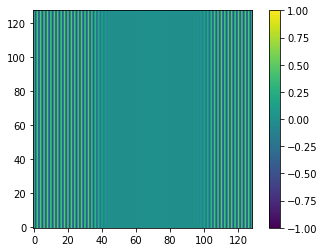

In [22]:
in_field, out_field = initialize_fields(NX, NY+1, NZ, mode="vertical-bars", order="C", ifirst=True)
in_field, out_field = array_to_gt_storage(in_field, out_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_1D_row_apply(in_field, out_field, N_ITER=N_ITER)
plot_field(out_field, ifirst=True)

In [30]:
%%timeit
in_field, out_field = initialize_fields(NX+1, NY, NZ, mode="vertical-bars", order="C", ifirst=True)
in_field, out_field = array_to_gt_storage(in_field, out_field, backend=backend, index=(0, 0, 0))
gt4py_1D_row_apply(in_field, out_field, N_ITER=N_ITER)

193 ms ± 571 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit
in_field, out_field = initialize_fields(NX+1, NY, NZ, mode="vertical-bars", order="F", ifirst=True)
in_field, out_field = array_to_gt_storage(in_field, out_field, backend=backend, index=(0, 0, 0))
gt4py_1D_row_apply(in_field, out_field, N_ITER=N_ITER)

200 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Interestingly, the Fortran-style memory layout is always a bit slower, even though in theory it should be faster with a rowwise stencil. It seems that GT4Py makes some specific optimization to a C-style layout.

## ToDo:
Complete 2D stencil \
Look for Taichi